In [2]:
import data_generator as data
import seaborn as sns
import matplotlib.pyplot as plt
import pickle #saving Python objects to disk (binary).
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import data_generator as data
from acceptance_loop import AcceptanceLoop
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Evaluation import Metric, AUC, BS, PAUC, ABR, Evaluation, bayesianMetric
from reject_inference import RejectInference, BiasAwareSelfLearning
import random
#from scorecard_selection import ScorecardSelector
#from code_02_simulation_results import SimulationResults

In [ ]:
# generate data
res = data.DataGenerator(

    n = 10000, #simulate 10000 rows.
    k_con = 10, #t10 continuous features
    k_bin = 1, #no binary features - the generator will create a dummy B1(doos/bad) column of ones internally.
    bad_ratio = 0.8,#80% labeled "BAD" by default
    #con_mean_bad_dif=[2,1], 
    con_mean_bad_dif=[-0.5, 1.0, 1.2, 0.0, 0.9, -0.2, 1.5, 0.4, 0.3, 0.8], #the continuous mean difference between GOOD and BAD for each of the 10 continuous features.
    con_nonlinear = 0, #no nonlinear transforms on continuous variables.
    #con_noise_var = 0.1, #low noise variance on continuous variables.
    con_var_bad_dif = 0, #the continuous variance difference between GOOD and BAD is 0.5 (so BAD variance = GOOD variance * 0.5). 
    # NOTE: SET CON_VAR_BAD_DIF != 0 can cause non SPD problem. See below for fix.
    covars= None,
    #covars = [[1, 0.2, 0.2, 1], [1, -0.2, -0.2, 1]], #specifies covariance matrices for the two continuous features for GOOD and BAD respectively.
    # bin_prob = 0.5, bin_mean_bad_dif = 0, bin_bad_ratio = 0.5,
    # bin_mean_con_dif = 0, bin_var_bad_dif = 0, bin_noise_var = 0.1,
    verbose = True, seed = 100

)
res.generate()
res.data

Generating 10 continuous features with 1 binary features
Simulating (1000 x 11) data set
Generating binary features...


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,BAD,B1
0,2.164744,2.723180,1.071479,1.707390,1.199825,2.031799,2.280629,2.164898,2.584638,0.737837,BAD,0
1,-4.424635,-2.982204,-3.405402,-3.543961,-5.878105,-2.537225,-3.143426,-2.825512,-2.882547,-3.428068,BAD,0
2,1.853843,-0.995886,1.490625,1.410345,2.480950,2.125365,0.664062,1.606259,2.101537,2.467253,BAD,0
3,-0.875013,-0.951239,-0.728271,-0.094515,-0.436262,0.420380,0.263057,-0.046513,1.068811,1.002331,BAD,0
4,-0.715368,-0.966078,-0.214143,-0.664898,-2.659023,1.707620,-0.745077,-1.053550,-0.192635,-0.126032,BAD,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2.469826,-1.641033,-0.657305,-0.544318,-0.577902,-0.671645,-0.161671,-0.050778,-2.632257,-0.331292,GOOD,1
996,-0.620459,1.306368,1.281911,-1.111713,0.813704,-1.151078,0.780362,-0.308961,0.778309,-0.004666,GOOD,1
997,-4.333158,-0.852553,-3.387808,-2.934446,-3.022573,-3.762938,-5.418740,-3.758561,-3.036923,-2.756206,GOOD,1
998,-0.926502,0.778085,0.715177,-0.639699,0.058890,-2.121783,0.108957,0.525615,-0.295312,-0.021081,GOOD,1


In [5]:
print("Has attribute rng?", hasattr(res, "rng"))
if hasattr(res, "rng"):
    print("Type of res.rng:", type(res.rng))
    # Does it already have multivariate_normal?
    print("Has multivariate_normal:", hasattr(res.rng, "multivariate_normal"))

Has attribute rng? False


In [7]:
# extract initial population
init_population = res.data
init_population.drop(columns=['B1'], inplace=True)
init_population['BAD'].map({'BAD':1, 'GOOD':0}) # maps strings to ints, but we keep 'BAD'/'GOOD' for better interpretability later.

top_percent = 0.2 # accept the top 20% by the business rule.

# accept applicants using a business rule on X1
# Identify indices of the top `top_percent` based on 'X1'
accepts_ind = init_population.index[init_population['X1'] >= init_population['X1'].quantile(1 - top_percent)]

# Select rows for current accepts and rejects
init_accepts = init_population.loc[accepts_ind] #DataFrame of accepted applicants (subset).
init_rejects = init_population.drop(accepts_ind) #DataFrame of rejected applicants (complement subset)

In [8]:
# Edge-case handling to ensure enough BAD labels among accepts

if (init_accepts['BAD'] == 'BAD').sum() < 4:
    # Adjust indices to ensure at least 4 'BAD' cases, ensures downstream model training has enough BAD examples among accepts.
    # threshold = init_population['X1'].quantile(1 - top_percent)
    # accepts_ind = init_population.index[init_population['X1'] >= threshold].tolist()
    # main_part = accepts_ind[:len(accepts_ind) - 4]
    # first_four = list(init_population.index[:4])
    # accepts_ind = main_part + first_four

    top_indices = init_population.index[init_population['X1'] >= init_population['X1'].quantile(1 - top_percent)]
    accepts_ind = list(top_indices[:len(accepts_ind) - 4]) + list(init_population.index[:4])
    init_accepts = init_population.loc[accepts_ind]
    init_rejects = init_population.drop(accepts_ind)

    #

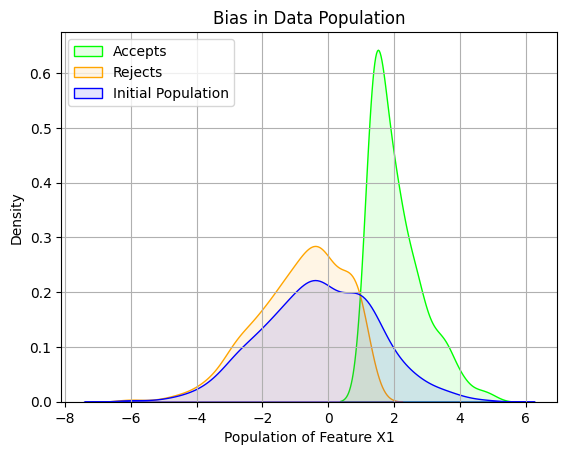

In [9]:
# if not os.path.exists('plots'):
#     os.makedirs('plots')
sns.kdeplot(init_accepts.iloc[:, 0], fill= True, color='lime', label='Accepts', alpha=0.1)
sns.kdeplot(init_rejects.iloc[:, 0], fill= True, color='orange', label='Rejects', alpha=0.1)
sns.kdeplot(init_population.iloc[:, 0], fill= True, color='blue', label='Initial Population', alpha=0.1)
plt.xlabel('Population of Feature X1')
plt.title('Bias in Data Population')
plt.legend()
plt.grid(True)
# plt.savefig(f'plots/population.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.close()

In [ ]:
######### HOLDOUT POPULATION ########

holdout_sample = 20000 # size of holdout data: 2*res.n

# generate holdout data
holdout = data.DataGenerator(n = holdout_sample, replicate = res, seed = 99999)
holdout.generate()
holdout_population = holdout.data

# safe X/y extraction
cols_to_drop = ['BAD']
if 'B1' in holdout_population.columns:
    cols_to_drop.append('B1')
x_holdout = holdout_population.drop(columns=cols_to_drop)
y_holdout = holdout_population['BAD'].map({'BAD':1, 'GOOD':0}).astype(int)

x_holdout = holdout_population.drop(columns=['BAD', 'B1'])
y_holdout = holdout_population['BAD'].map({"BAD":1, "GOOD":0})


Generating 10 continuous features with 1 binary features
Simulating (20000 x 11) data set
Generating binary features...
(20000, 10) (20000,)


In [11]:
# sanity checks
print("holdout shape:", holdout_population.shape)
print("x_holdout shape:", x_holdout.shape, "y_holdout shape:", y_holdout.shape)
print("BAD dist:", holdout_population['BAD'].value_counts(normalize=True))
print("Any missing in X:", x_holdout.isna().any().any())

holdout shape: (20000, 12)
x_holdout shape: (20000, 10) y_holdout shape: (20000,)
BAD dist: BAD
BAD     0.64925
GOOD    0.35075
Name: proportion, dtype: float64
Any missing in X: False


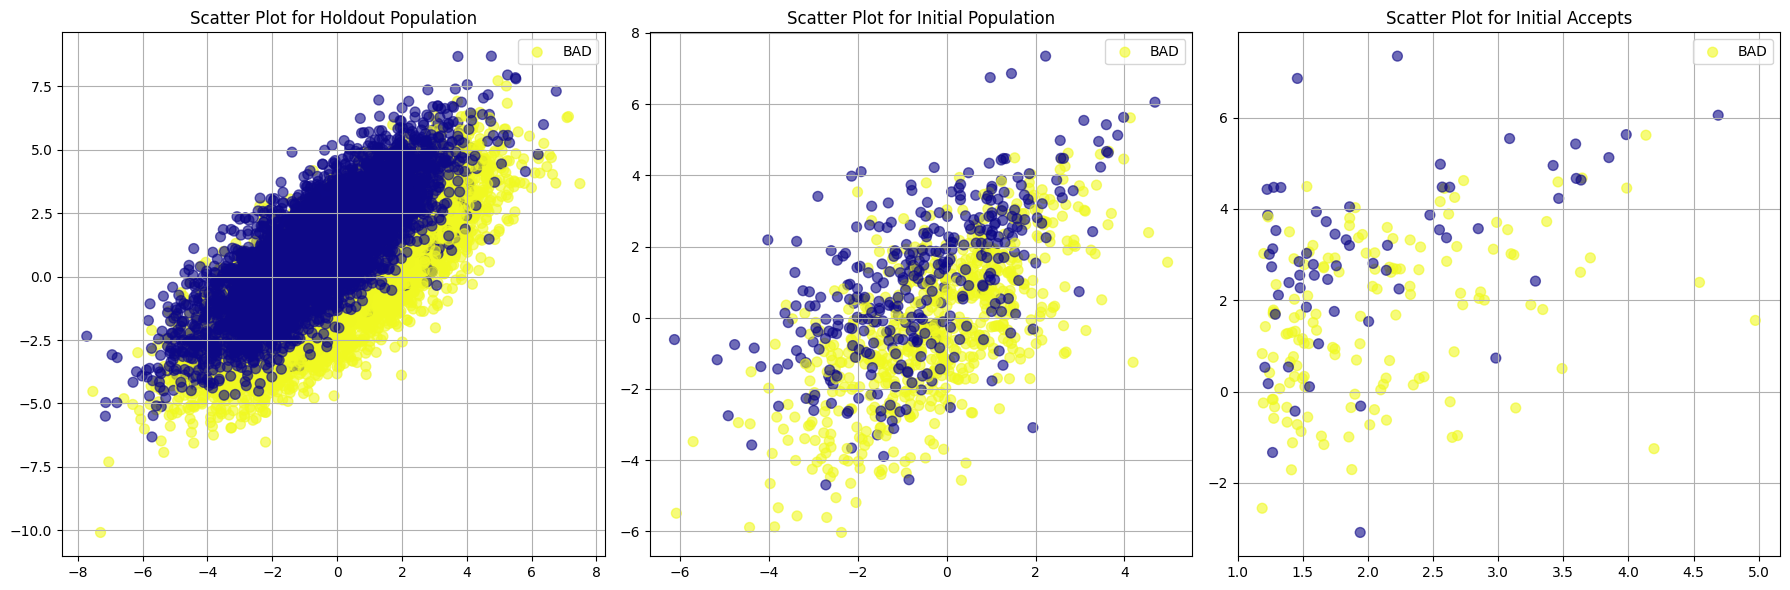

In [12]:
######### Visualize Data Set #########
fig, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].scatter(holdout_population['X1'], holdout_population['X2'], c=holdout_population['BAD'].map({'BAD':1, 'GOOD':0}), cmap='plasma', alpha=0.6, s=50, label="BAD")
ax[0].set_title('Scatter Plot for Holdout Population')
ax[0].legend()
ax[0].grid()

ax[1].scatter(init_population['X1'], init_population['X2'], c=init_population['BAD'].map({'BAD':1, 'GOOD':0}), cmap='plasma', alpha=0.6, s=50, label="BAD")
ax[1].set_title('Scatter Plot for Initial Population')
ax[1].legend()
ax[1].grid()

ax[2].scatter(init_accepts['X1'], init_accepts['X2'], c=init_accepts['BAD'].map({'BAD':1, 'GOOD':0}), cmap='plasma', alpha=0.6, s=50, label="BAD")
ax[2].set_title('Scatter Plot for Initial Accepts')
ax[2].legend()
ax[2].grid()

plt.tight_layout()
plt.show()

above graphic looks a lot,plotting - subsample for better visibility

Overplotting and perceptual limits: with tens of thousands of points many markers overlap and add noise; the human eye cannot resolve every point anyway. A dense plot often looks the same (or worse) with all points versus a well‑chosen sample.

Statistical stability: many features (means, variances, density peaks) converge quickly — a few thousand rows already estimate them well for most purposes.


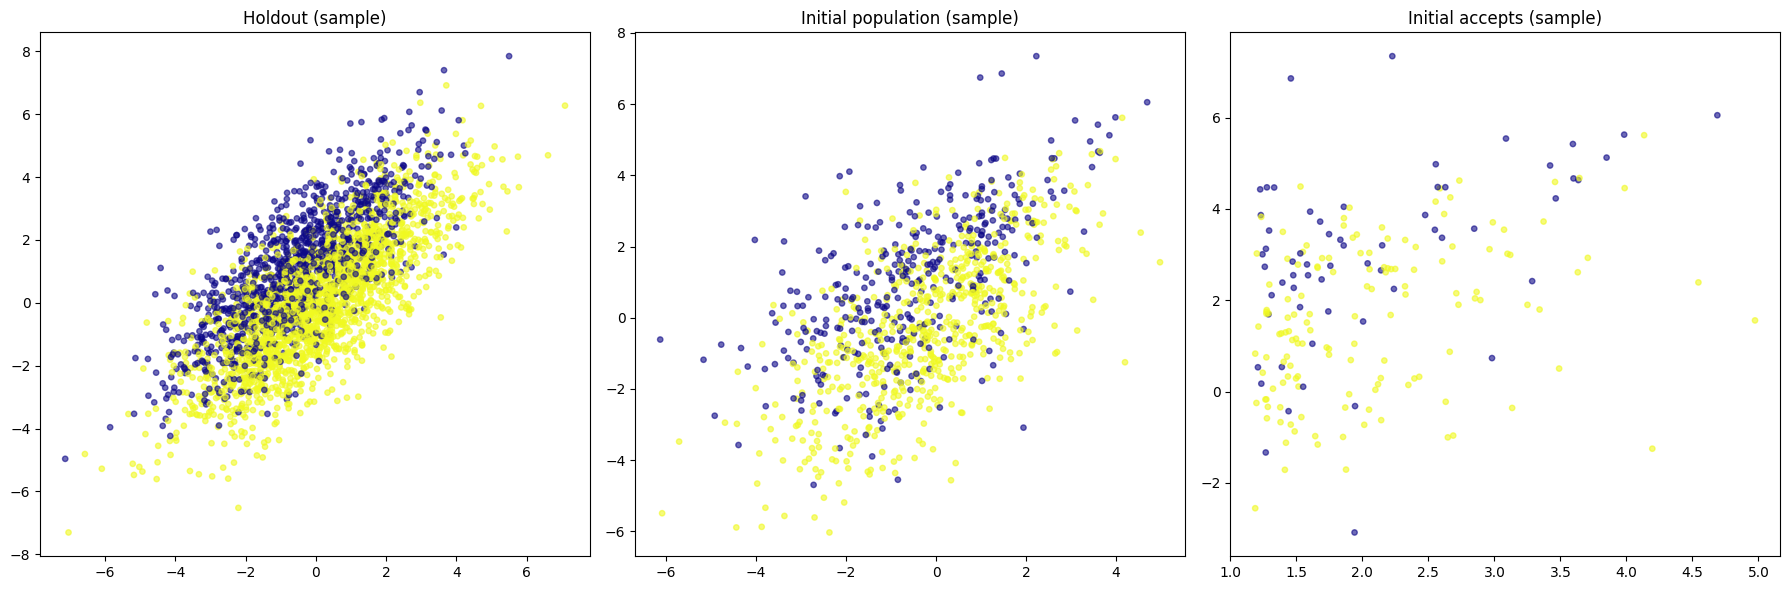

In [13]:

sample_holdout = holdout_population.sample(n=min(3000, len(holdout_population)), random_state=1)
sample_init_population = init_population.sample(n=min(3000, len(init_population)), random_state=1)
sample_init_accepts = init_accepts.sample(n=min(3000, len(init_accepts)), random_state=1)

fig, ax = plt.subplots(1,3, figsize=(18,6))

#holdout
ax[0].scatter(sample_holdout['X1'], sample_holdout['X2'],
              c=sample_holdout['BAD'].map({'BAD':1,'GOOD':0}), cmap='plasma', alpha=0.6, s=15)
ax[0].set_title('Holdout (sample)')

#initial population
ax[1].scatter(sample_init_population['X1'], sample_init_population['X2'],
              c=sample_init_population['BAD'].map({'BAD':1,'GOOD':0}), cmap='plasma', alpha=0.6, s=15)
ax[1].set_title('Initial population (sample)')

#initial accepts
ax[2].scatter(sample_init_accepts['X1'], sample_init_accepts['X2'],
              c=sample_init_accepts['BAD'].map({'BAD':1,'GOOD':0}), cmap='plasma', alpha=0.6, s=15)
ax[2].set_title('Initial accepts (sample)')

plt.tight_layout()
plt.show()

##### More realwolrd data-  acceptence loop
lenders score applicants, accept a subset, and observe outcomes only for those accepted. That selection produces biased training data (you don’t observe outcomes for rejects).
The acceptance loop simulates this dynamic process: train a model on currently observed labeled data (accepts),score new applicants,accept a top slice (business rule: top_percent), observe outcomes for accepts (because you “issue credit” in the simulation), add those observed accepts to the training pool and keep rejects as unlabeled, repeat many iterations.

with AL we observe how selection bias accumulates, how model performance drifts, and how reject‑inference methods (BASL) and oracle methods compare.

#### model detail: (Acceptence_loop.py)
- accept‑only model (trained only on observed accepts),
- oracle model (trained on full labels for accepts + rejects — only available in simulation),
- corrected model (BASL-bias‑aware self‑learning reject‑inference method).
- Run the simulation stats_list, holdout_accept_preds_bad, basl_preds_bad, oracle_preds_bad, _, _ = acceptance_loop.run()

In [14]:
#testing SPD
for _ in range(10):
    s1, s2 = res.generate_cov(np.zeros(res.k_bin if res.k_bin > 0 else 1))
    e1 = np.linalg.eigvalsh(s1)
    e2 = np.linalg.eigvalsh(s2)
    assert e1.min() >= -1e-12, "sigma1 not PSD"
    assert e2.min() >= -1e-12, f"sigma2 not PSD (min eig {e2.min()})"
print("generate_cov validated: sigma1 and sigma2 are PSD")

generate_cov validated: sigma1 and sigma2 are PSD


Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features
Simulating (100 x 11) data set
Generating binary features...
Generating 10 continuous features with 1 binary features

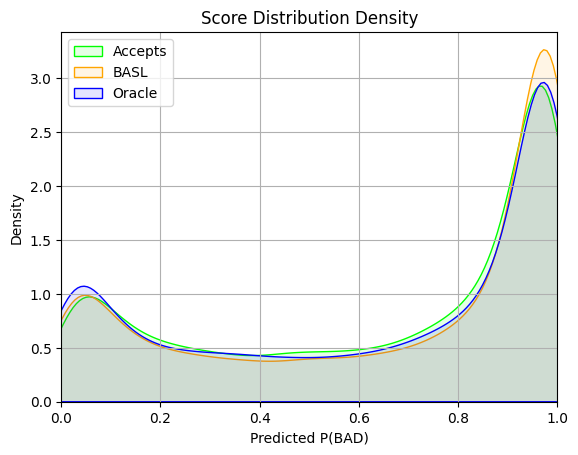

In [ ]:
#initialize iteration 300
acceptance_loop = AcceptanceLoop(
    n_iter = 300,
    current_accepts= init_accepts,
    current_rejects= init_rejects,
    holdout= holdout_population,
    res=res,
    top_percent= top_percent) #bussiness rule: top 20% accepted each iteration as set above

stats_list, holdout_accept_preds_bad, basl_preds_bad, oracle_preds_bad, _, _ = acceptance_loop.run()
sns.kdeplot(holdout_accept_preds_bad, fill= True, color='#00FF00', label='Accepts', alpha=0.1)
sns.kdeplot(basl_preds_bad, fill= True, color='orange', label='BASL', alpha=0.1)
sns.kdeplot(oracle_preds_bad, fill= True, color='blue', label='Oracle', alpha=0.1)
plt.xlabel('Predicted P(BAD)')
plt.title('Score Distribution Density')
plt.legend()
plt.xlim(0, 1)
plt.grid(True)

if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig(f'Bias in prediction.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

with open('stats_list.pkl', 'wb') as f:
    pickle.dump(stats_list, f)

### Findings:
when the continuous variance difference between GOOD and BAD con_var_bad_dif != 0, could cuz non SPD problem.

n_iter

In [ ]:

# potencial non SPD problem fixing



### Core parameters and storage*

#### Purpose**  
Hold configuration and the place to store the generated dataset + metadata.

#### Key parameters**  
`n`:  total number of rows (observations) to generate.

`k_con`: number of continuous features (X1..Xk) to simulate, controls dimensionality of multivariate normals and the covariance matrices. Pitfall: high `k_con` with small n can lead to singular covariances / unstable estimation.

`k_bin`: number of binary (categorical, 0/1) features to create.

`bad_ratio`: fraction labeled "BAD" (like defaults/bad accounts).baseline proportion when no binary-combo-specific value is provided. Typical: small values (0.01–0.2) for realistic credit; 0.5 for balanced synthetic experiments. Pitfall: extreme imbalance (very small bad_ratio) requires very large n to get enough BAD examples.

`con_var_bad_dif`: (float or mechanism)the probability/degree that covariance elements differ between BAD and GOOD. *Effect: nonzero → more complicated decision boundary; models may need to handle heteroskedasticity. Typical: 0 (no covariance change) to moderate values (0.1–0.5). Pitfall: large changes can produce non-PSD covariance unless handled carefully.*

`con_mean_bad_dif`: (numeric or array) amount by which BAD observations’ continuous-feature means differ from GOOD.Typical: 0.1–2 for synthetic tests; tune to control signal strength. Can be a scalar (applied to all features) or can later change to vectors to vary by feature.

`con_nonlinear`: fraction of continuous features to make nonlinear. Typical: 0–0.5 for experimentation. Tip: transforms are applied before adding Gaussian noise in this code; order affects distributions. eg: k_con = 4, con_nonlinear = 0.5 → round(4*0.5)=2 variables

`con_noise_var`: standard deviation of Gaussian noise added to continuous features. simulates measurement error and reduces signal-to-noise ratio.Higher → more overlap between classes and noisier features.

`covars`:user-provided covariance matrices to use instead of generating random ones.

`bin_prob`:Bernoulli parameter(s) for each binary feature (probability of 1).Controls prevalence of binary attributes and thus how often different combos appear. Effect: affects combo frequencies and therefore how many observations are available per strata. Typical: 0.1–0.9; can pass a single float to apply to all binaries or a list per-feature.

`bin_noise_var `: probability of flipping a binary bit (inject noise).  Simulates measurement error or mis-reported attributes.

`bin_mean_bad_dif`: (scalar or list) additional mean shift for continuous features associated with binary==1 toward BAD.

`bin_mean_con_dif`:  (scalar or list): base mean difference for continuous features associated with binary levels (applied to GOOD baseline).

`bin_bad_ratio`: per-binary-component influence on local BAD ratio; used to compute combo-specific bad rates.simulates differential default rates across subgroups (important for sampling bias experiments). each combo’s bad_ratio = function(mean of bin_bad_ratio * combo_vals).

`bin_var_bad_dif `:used to compute combo-specific probability of varying covariances between BAD/GOOD. allow the binary attributes to change variance structure (heteroskedastic combos).

`verbose`: (bool)print progress/info messages.

`seed`: RNG seed for reproducibility (used via numpy Generator).

`replicate`: allow re-using parameters from previous generation.  allows creating multiple datasets with the same parameterization or reusing covariances/means across runs (e.g., for controlled experiments).

Output placeholders: `self.data` will hold final pandas DataFrame, `con_params` will record the per-combo means/covariances.(dict with 'means', 'covar', 'combo') `self:arg`: saved configuration dictionary (parameters used).